Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Removed 0 incomplete rows; 60 remain.


,Configuration,Download_mean,Download_median,Download_sd,Upload_mean,Upload_median,Upload_sd,Latency_mean,Latency_median,Latency_sd
0,Baseline,74.250000,74.100000,1.100000,18.610000,18.600000,0.300000,6.770000,6.800000,0.300000
1,VPN Only,69.690000,69.900000,1.040000,17.270000,17.200000,0.400000,26.930000,26.300000,2.390000
2,VPN - Tor,21.370000,21.800000,1.690000,13.390000,13.600000,0.830000,170.760000,138.700000,69.000000
3,VPN - Tor - VPN,21.640000,22.000000,1.220000,13.370000,13.600000,0.670000,195.330000,136.000000,97.530000


,Configuration,Shapiro_W,p_normal,t_vs_baseline,p_vs_baseline
0,Baseline,0.968000,0.821700,nan,nan
1,VPN Only,0.968000,0.824700,11.660000,0.000000
2,VPN - Tor,0.920000,0.193600,101.520000,0.000000
3,VPN - Tor - VPN,0.905000,0.114400,123.710000,0.000000


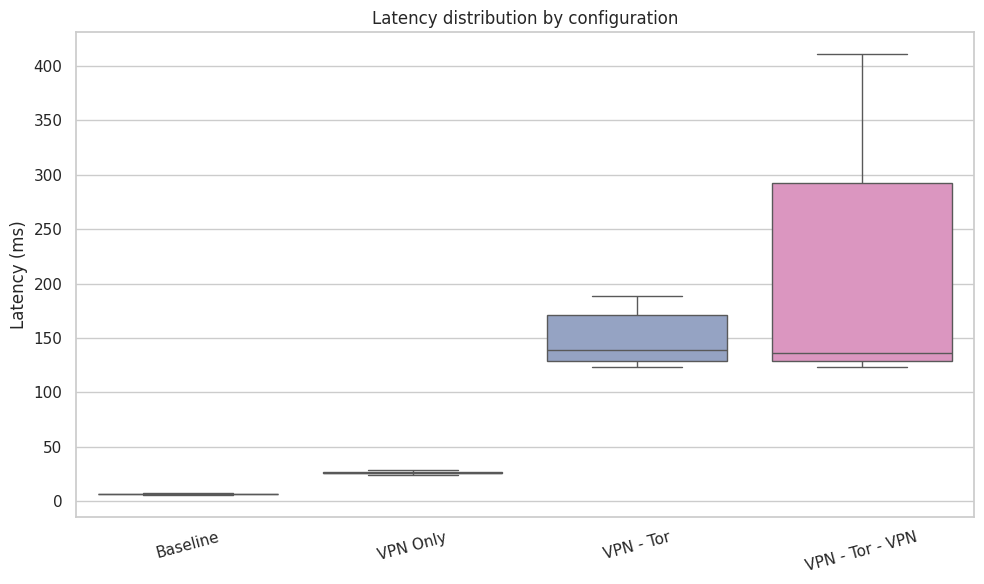

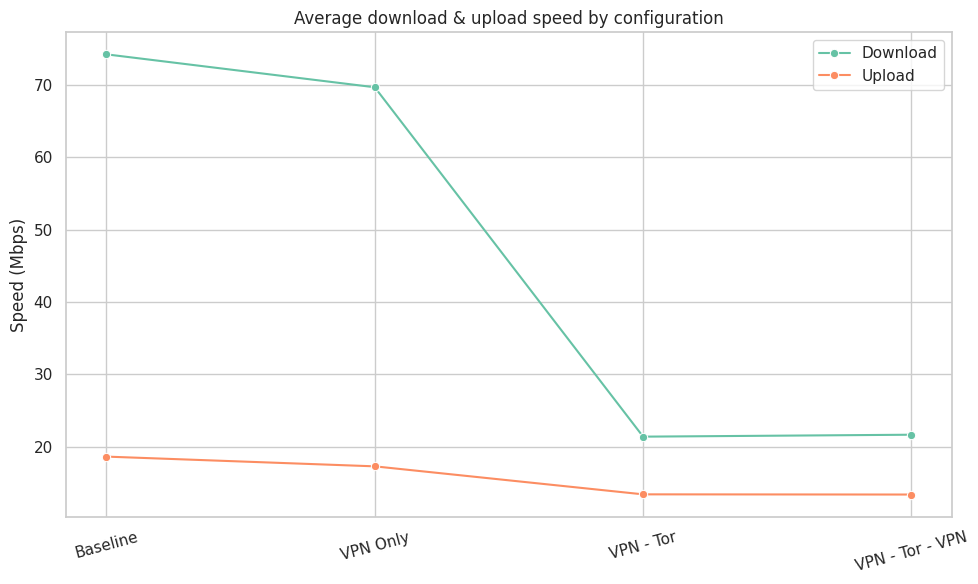

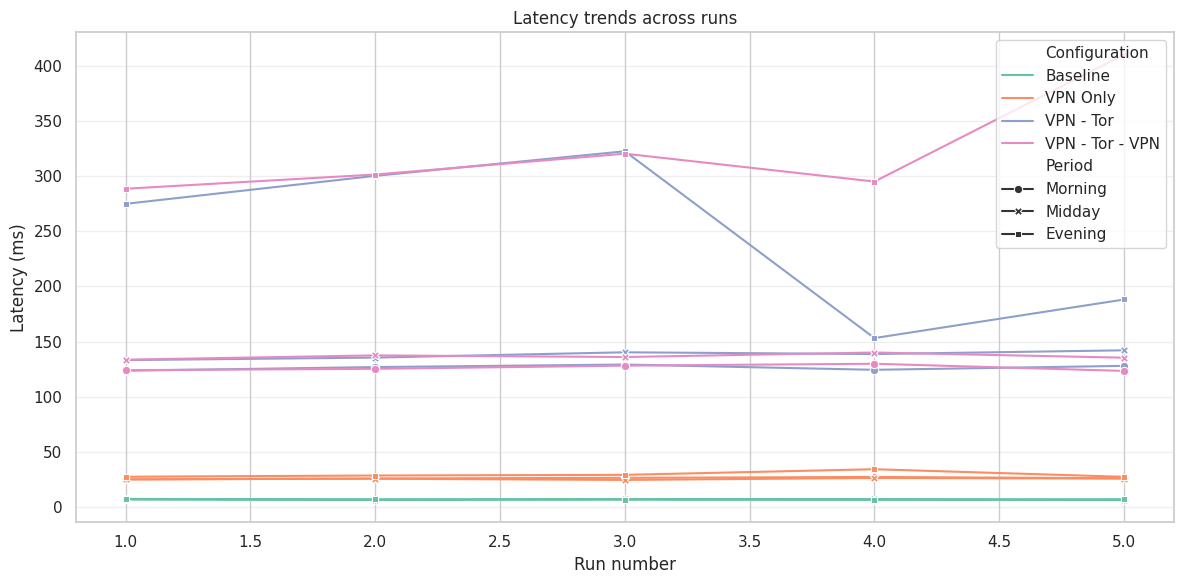

In [7]:
# --- STEP 0: Imports & Style -----------------------------------------------
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind

warnings.simplefilter("ignore", category=FutureWarning)  # Hide unavoidable futures
sns.set_theme(style="whitegrid", palette="Set2")          # Global seaborn style

# --- STEP 1: Mount Drive & Load Data ---------------------------------------
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/FYP/iperf_FYP_measurements.csv"
df = pd.read_csv(CSV_PATH)

ordered_cfgs = ["Baseline", "VPN Only", "VPN - Tor", "VPN - Tor - VPN"]
df["Configuration"] = pd.Categorical(df["Configuration"], categories=ordered_cfgs, ordered=True)

# Convert dtypes and drop incomplete rows
num_cols = ["Download_Mbps", "Upload_Mbps", "Latency_ms"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df["Run"] = df["Run"].astype(int)

df_clean = df.dropna(subset=num_cols).copy()
print(f"Removed {len(df) - len(df_clean)} incomplete rows; {len(df_clean)} remain.")

# --- STEP 2: Descriptive Statistics ----------------------------------------
summary = (
    df_clean.groupby("Configuration", observed=True)      # observed=True -> no warning
           .agg(Download_mean=("Download_Mbps", "mean"),
                Download_median=("Download_Mbps", "median"),
                Download_sd=("Download_Mbps", "std"),
                Upload_mean=("Upload_Mbps", "mean"),
                Upload_median=("Upload_Mbps", "median"),
                Upload_sd=("Upload_Mbps", "std"),
                Latency_mean=("Latency_ms", "mean"),
                Latency_median=("Latency_ms", "median"),
                Latency_sd=("Latency_ms", "std"))
           .round(2)
           .reset_index()
)
display(summary.style.set_caption("Statistical summary (mean/median/s.d.)"))

# --- STEP 3: Normality & t-tests ------------------------------------------
def normality_and_ttests(df_, configs):
    """Return a tidy DataFrame of Shapiro-Wilk and Welch t-test results."""
    records = []
    base = df_[df_["Configuration"] == "Baseline"]["Download_Mbps"]
    for cfg, grp in df_.groupby("Configuration", observed=True):
        # Shapiro–Wilk
        W, p_norm = shapiro(grp["Download_Mbps"])
        # Welch t-test v Baseline (skip baseline vs itself)
        if cfg != "Baseline":
            t_stat, p_val = ttest_ind(base, grp["Download_Mbps"], equal_var=False)
        else:
            t_stat, p_val = np.nan, np.nan
        records.append({"Configuration": cfg,
                        "Shapiro_W": round(W, 3),
                        "p_normal": round(p_norm, 4),
                        "t_vs_baseline": round(t_stat, 2),
                        "p_vs_baseline": round(p_val, 4)})
    return pd.DataFrame(records)

test_results = normality_and_ttests(df_clean, ordered_cfgs)
display(test_results.style.set_caption("Shapiro-Wilk & Welch’s t-tests"))

# --- STEP 4: Box-plot (Latency) -------------------------------------------
# palette dict avoids seaborn’s future warning
palette_dict = dict(zip(ordered_cfgs, sns.color_palette("Set2", n_colors=len(ordered_cfgs))))

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean,
            x="Configuration",
            y="Latency_ms",
            palette=palette_dict,
            showfliers=False)
plt.title("Latency distribution by configuration")
plt.ylabel("Latency (ms)")
plt.xlabel("")                       # cleaner without repetitive axis title
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# --- STEP 5: Average Download & Upload Speeds ------------------------------
avg = (df_clean.groupby("Configuration", observed=True)[["Download_Mbps", "Upload_Mbps"]]
                 .mean()
                 .reset_index())

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg, x="Configuration", y="Download_Mbps",
             marker="o", label="Download")
sns.lineplot(data=avg, x="Configuration", y="Upload_Mbps",
             marker="o", label="Upload")
plt.title("Average download & upload speed by configuration")
plt.ylabel("Speed (Mbps)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.legend(title="", loc="upper right")
plt.tight_layout()
plt.show()

# --- STEP 6: Latency Trend over Runs --------------------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clean,
             x="Run",
             y="Latency_ms",
             hue="Configuration",
             style="Period",
             markers=True,
             dashes=False)
plt.title("Latency trends across runs")
plt.ylabel("Latency (ms)")
plt.xlabel("Run number")
plt.grid(True, axis="y", alpha=.3)
plt.tight_layout()
plt.show()
